# Baseball Data Exploration

In this project, I'm going to explore the Kaggle baseball data set.  This file reads in the teams data from the sqlite database, does some data exploration and visualization, and finally I will do some dimensionality reduction (PCA) and unsupervised clustering (K-means) to see if there's anything interesting there.

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

The data can be found in a sqlite database which I downloaded from the Kaggle datasets site.  I read the team table into a pandas DataFrame called teams.

I filter the data on years after 1949 so that we have more modern data.

I also filter on seasons with at least 150 games played.  If a team has played fewer games, their overall statistics is more likely to be vastly different from teams that played more games.  I will also convert the counting stats to per game stats in order to control for different season lengths.

In [2]:
conn = sqlite3.connect("/home/craig/Documents/ML_Projects/Kaggle/Baseball/database.db")
teams = pd.read_sql_query("SELECT * FROM team", conn)
teams = teams.loc[teams['year'] >= 1950].loc[teams['g'] >= 150]
teams.shape

(1540, 48)

I'm going to inspect the shape of the data, the data types of the columns, and then remove a couple of unnecessary identifier columns.  Some columns that should be numeric are not currently formatted as such, so I will need to cast those as well.

In [3]:
teams.shape  # 1540 x 48 columns
teams.dtypes

def removeColumns(data, ids=[]):
    try:
        new_data = data.drop(labels=ids, axis=1,inplace=False)
    except:
        print("Columns already removed")
    return new_data

# remove unwanted ID columns
teams = removeColumns(teams, ids=['team_id_lahman45', 'team_id_retro'])

# create new DataFrame that only contains numeric variables
cols = ['year', 'league_id','franchise_id','div_id','div_win','wc_win',
        'lg_win','ws_win','team_id_br','name','park','team_id','rank']
teams_num = removeColumns(teams, cols)


In [4]:
# Convert all remaining columns to numeric
teams_num = teams_num.apply(pd.to_numeric)
# teams_num.dtypes
teams_num.describe()

,g,ghome,w,l,r,ab,h,double,triple,hr,...,ha,hra,bba,soa,e,dp,fp,attendance,bpf,ppf
count,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,...,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1540.000000,1.540000e+03,1540.000000,1540.000000
mean,160.949351,80.465584,80.386364,80.386364,707.146753,5486.649351,1419.718831,251.875325,35.157143,143.959740,...,1419.717532,143.959740,529.093506,945.362987,124.063636,151.265584,0.976630,1.838084e+06,100.196753,100.196104
std,2.564825,1.451216,11.804370,11.751132,91.136421,124.238574,91.023190,42.176676,10.858233,38.909447,...,94.376185,32.274685,70.191442,180.683886,24.742938,18.501047,0.006236,8.347442e+05,4.662027,4.764143
min,151.000000,68.000000,40.000000,43.000000,454.000000,5028.000000,1092.000000,151.000000,11.000000,49.000000,...,1087.000000,65.000000,344.000000,437.000000,54.000000,96.000000,0.960000,2.471310e+05,88.000000,88.000000
25%,161.000000,81.000000,72.000000,72.000000,645.000000,5428.000000,1359.000000,218.000000,27.000000,115.000000,...,1355.750000,120.000000,479.750000,817.000000,106.000000,138.000000,0.970000,1.145530e+06,97.000000,97.000000
50%,162.000000,81.000000,81.000000,80.000000,703.500000,5503.000000,1415.000000,252.000000,34.000000,142.000000,...,1417.000000,143.000000,525.000000,939.500000,124.000000,151.000000,0.980000,1.751169e+06,100.000000,100.000000
75%,162.000000,81.000000,89.000000,89.000000,766.000000,5569.250000,1480.000000,283.000000,41.000000,169.000000,...,1483.000000,167.000000,574.000000,1065.250000,140.000000,164.000000,0.981000,2.424773e+06,103.000000,103.000000
max,165.000000,84.000000,116.000000,120.000000,1027.000000,5781.000000,1684.000000,376.000000,79.000000,264.000000,...,1734.000000,241.000000,801.000000,1450.000000,210.000000,215.000000,0.991000,4.483350e+06,127.000000,127.000000


Next I'm going to create few variables based on basic baseball statistics that are generally thought to be indicative of team performance:  Slugging Percentage, On-base Percentage, and Walks+Hits per Inning Pitched.  The first two variables are often thought to be among the most important basic statistics for batters, while the third is an important pitching statistics.  I'm also going to create a separate singles variables, since doubles/triples/home runs are contained within the hits statistic, we can remove some of the relationship that we know to exist.  It will also make other statistics easier to calculate.

In [5]:
# First, we need to deal with NaN values in hbp and sf.  Let's impute NaNs to the mean value of the column.
# It's likely that these values were simply not tracked for earlier years, so we don't want to artificially
# devalue these stats for earlier years.
teams_num.isnull().sum()

teams_num['sf'].fillna(teams_num['sf'].mean(), inplace=True)
teams_num['hbp'].fillna(teams_num['hbp'].mean(), inplace=True)
teams_num['cs'].fillna(teams_num['cs'].mean(), inplace=True)

In [6]:
# Now we can create a singles column and games away column, as well as the more complicated stats mentioned above.
teams_num['single'] = teams_num['h'] - teams_num['double'] - teams_num['triple'] - teams_num['hr']
teams_num['gaway'] = teams_num['g'] - teams_num['ghome']
teams_num['obp'] = (teams_num['h'] + teams_num['bb'] + teams_num['hbp']) / (teams_num['ab'] + teams_num['bb'] + teams_num['hbp'] + teams_num['sf'])
teams_num['slg'] = (teams_num['single'] + teams_num['double']*2 + teams_num['triple']*3 + teams_num['hr']*4) / teams_num['ab']
teams_num['whip'] = (teams_num['bba'] + teams_num['ha']) / (teams_num['ipouts'] / 3)
teams_num['attendance'] = teams_num['attendance'] / 1000000 # units in millions

# remove columns that we've made better columns for
teams_num = removeColumns(teams_num, ['h'])
teams_num.columns

Index(['g', 'ghome', 'w', 'l', 'r', 'ab', 'double', 'triple', 'hr', 'bb', 'so',
       'sb', 'cs', 'hbp', 'sf', 'ra', 'er', 'era', 'cg', 'sho', 'sv', 'ipouts',
       'ha', 'hra', 'bba', 'soa', 'e', 'dp', 'fp', 'attendance', 'bpf', 'ppf',
       'single', 'gaway', 'obp', 'slg', 'whip'],
      dtype='object')

In [7]:
# .div method is giving me trouble, crashing kernel
cols = ['ghome','gaway','w','l','r','ab','double','triple','hr','bb','so','sb','cs','hbp','sf','ra','er',\
        'cg','sho','sv','ha','hra','bba','soa','e','dp','attendance','single']
for column in cols:
    teams_num[column] = teams_num[column] / teams_num['g']


In [8]:
teams_num.head()

,g,ghome,w,l,r,ab,double,triple,hr,bb,...,dp,fp,attendance,bpf,ppf,single,gaway,obp,slg,whip
1183,154,0.500000,0.610390,0.389610,6.668831,35.818182,1.863636,0.396104,1.045455,4.668831,...,1.175325,0.98,0.008728,111,108,7.506494,0.500000,0.385130,0.463561,1.586637
1184,155,0.503226,0.574194,0.419355,5.464516,34.606452,1.593548,0.296774,1.251613,3.916129,...,1.180645,0.97,0.007651,103,99,6.283871,0.496774,0.349831,0.444072,1.431246
1185,156,0.506410,0.532051,0.455128,5.032051,34.378205,1.576923,0.230769,0.948718,3.942308,...,0.935897,0.97,0.006054,94,93,6.288462,0.493590,0.342519,0.405184,1.418773
1186,156,0.506410,0.384615,0.602564,4.006410,33.717949,1.102564,0.301282,0.596154,3.532051,...,1.160256,0.97,0.005009,97,98,6.769231,0.493590,0.334095,0.363688,1.541392
1187,154,0.506494,0.415584,0.577922,4.175325,33.961039,1.454545,0.305195,1.045455,3.110390,...,1.097403,0.96,0.007571,99,102,5.623377,0.493506,0.315519,0.401338,1.491612


Now, in order to control for different numbers of total games, I'm going to divide some of the counting statistics by 'g'

In [9]:
# remove the games column
teams_num = removeColumns(teams_num, ['g'])

Next I want to check out any correlation among the variables using a correlation heatmap.  Since there are quite a few variables, it will be easier to see areas of concern than by look at correlation coefficients

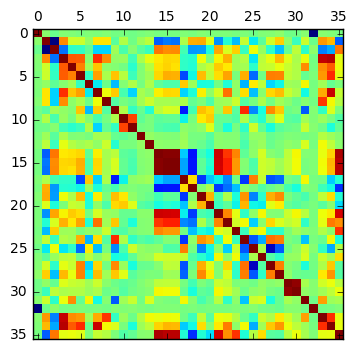

In [10]:
plt.matshow(teams_num.corr())
plt.show()

We can see some interesting correlation between variables 2 and 3, around 3-6, and around 14-18.
There are a few more pockets in the plot, but I'll inspect these for now, and just remain cognizant
that I might need to deal with multicollinearity at some point.

1.  Columns 2 and 3 are losses and runs.  These are negatively correlated.  This makes perfect sense, if a teams scores
    fewer runs, we'd expect them to win fewer games.
2.  Columns 3-6 are runs, at bats, doubles and triples.  These are all positively correlated - this makes sense
    that a team with more offensive productions would have more runs and more at bats.
3.  Columns 14-18 are runs against, earned runs allowed, earned run average, complete games pitched and shutouts pitched.
    The first three are all positively correlated and indicate poor pitching performance.  The last two are 
    negatively correlated with the first three, because they indicate good pitching performance.
    
Overall, the correlation we see in the data seems to make sense

In [13]:
teams_num[[2,3]] # losses and runs
teams_num[[3,4,5,6]] # runs, ab, double, triple
teams_num[[14,15,16,17,18]].head() # ra, er, era are all positively correlated, cg and sho are negatively correlated with those

,l,r
1183,0.389610,6.668831
1184,0.419355,5.464516
1185,0.455128,5.032051
1186,0.602564,4.006410
1187,0.577922,4.175325
1188,0.568627,4.274510
1189,0.400000,5.200000
1190,0.375796,5.331210
1191,0.441558,4.772727
1192,0.361290,5.896774


Next, I want to standardize these variables and then generate some clusters using a few different clustering methods.  This will help us identify similarities among teams in terms of their statistical performance.

In my first clustering attempt, I'm going to get the first two principal components so that we can easily visualize the clusters.  From there I will either cluster on the variables themselves or use additional principal components to get more precise clusters.


In [14]:
x = teams_num.values # returns numpy array of the data
standard_scaler = StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
teams_num_sc = pd.DataFrame(x_scaled)

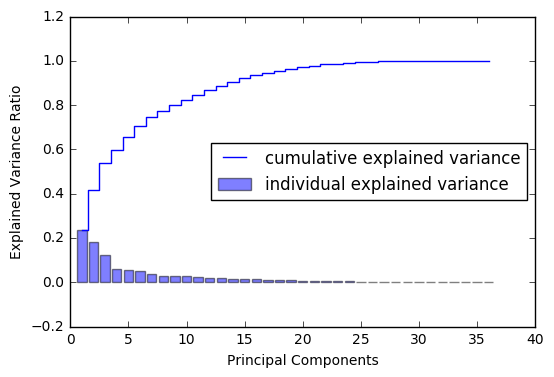

In [15]:
# Principal Components Function
def getPCAProjectionMatrix(dat, return_components=None):
    # Note: from Python ML, Raschka - custom code to expand from first 2 PCs to any number
    cov_mat = np.cov(dat.T)
    eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
    eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range (len(eigen_vals))]
    eigen_pairs.sort(reverse=True)
    if not return_components:
        return_components = len(eigen_pairs)
    pairs=[]
    for i in range(return_components):
        pairs.append(eigen_pairs[i][1][:,np.newaxis])
    pairs=tuple(pairs)
    projection_matrix = np.hstack(pairs)
    transformed_data = dat.dot(projection_matrix)
    return transformed_data, projection_matrix, eigen_vals, eigen_vecs
    
def plotPCAVarianceExplained(eigen_vals):
    # Note: from Python Machine Learning, Raschka (awesome plot, thanks!)
    tot = sum(eigen_vals)
    var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    plt.bar(range(1, len(eigen_vals)+1), var_exp, alpha=0.5, align='center', label='individual explained variance')
    plt.step(range(1, len(eigen_vals)+1), cum_var_exp, where='mid', label='cumulative explained variance')
    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Principal Components')
    plt.legend(loc='best')
    plt.show()

# Get the PCA projection matrix to transform our data.  Get all PCs the first time for plotting.
_, _, eigen_vals, _ = getPCAProjectionMatrix(x_scaled)

# Plot the amount of variance explained by principal component
plotPCAVarianceExplained(eigen_vals)


In [16]:
# Get the first two PCs for clustering.  We can see above that the first 2 PCs account for a little more than 40%
# of the variation in the data.
x_scaled_pca, projection, eigen_vals, eigen_vecs = getPCAProjectionMatrix(x_scaled, 2)
x_scaled_pca.shape

(1540, 2)

Now that I have a two-dimensional data set, I'm going to do some clustering and plotting.  I will use the k-means clustering algorithm to start.  This algorithm starts with the full scattering of data, and then creates initial cluster centroids.  For each observation, we calculate the Euclidean distance from each of the randomly created cluster centroids.  After all points have been assigned to a cluster, the centroids are recalculated by taking the average of all points within the cluster, and the process repeats.  We end up with clusters containing the observations that are closest to each other.

Note:  We use the k-means++ algorithm as our initialization method (rather than randomly choosing starting centroids).  This method randomly selects the first centroid, and then each subsequent centroid is chosen randomly (with non-uniform probability) from among the remaining points.  The probability for a point to be chosen as the next centroid is proportional to its distance from the nearest prevously assigned centroid.  This method generally gives more consistent results than random initialization, and generally should require fewer algorithm iterations.

In [17]:
cluster = KMeans(n_clusters=4, init='k-means++', max_iter=500, random_state=0)
x_cluster = cluster.fit_predict(x_scaled_pca)
x_cluster

array([0, 0, 3, ..., 2, 2, 0], dtype=int32)

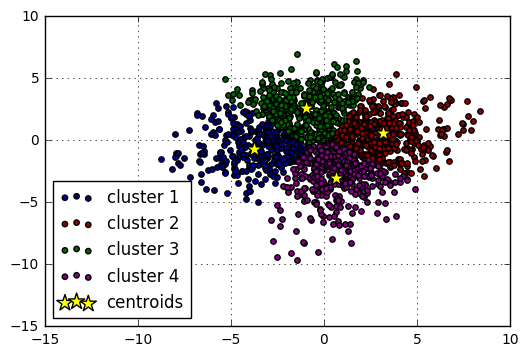

In [21]:
plt.scatter(x_scaled_pca[x_cluster==0,0],
            x_scaled_pca[x_cluster==0,1],
            s=15,
            c='darkblue',
            label='cluster 1')
plt.scatter(x_scaled_pca[x_cluster==1,0],
            x_scaled_pca[x_cluster==1,1],
            s=15,
            c='darkred',
            label='cluster 2')
plt.scatter(x_scaled_pca[x_cluster==2,0],
            x_scaled_pca[x_cluster==2,1],
            s=15,
            c='darkgreen',
            label='cluster 3')
plt.scatter(x_scaled_pca[x_cluster==3,0],
            x_scaled_pca[x_cluster==3,1],
            s=15,
            c='purple',
            label='cluster 4')
plt.scatter(cluster.cluster_centers_[:,0],
            cluster.cluster_centers_[:,1],
            s=150,
            marker='*',
            c='yellow',
            label='centroids')
plt.legend(loc=3)
plt.grid()
plt.show()

We can see when we use four clusters we have:
1.  One cluster of teams that have very high values along the x-axis
2.  One cluster with low values along the x-axis
3.  One cluster with middle values on the x-axis and higher values along the y-axis
4.  One cluster with middle values on the x-axis and lower values along the y-axis

Without knowing anything about two principal components, I can't really describe the clusters at this point.  I'd need to either determine how the PCs vary with the actual variables, or describe each cluster based on the variables.  

Additionally, I chose four clusters kind of randomly.  In order to find a more optimal number of clusters, I'll want to run the K-means algorithm several times with different values for k.  I then can plot SSE against the number of clusters, and choose the value for K when the SSE starts to approximately level off (this is sometimes called the 'elbow plot', since a good choice for K is around the point where the plot forms an elbow shape).

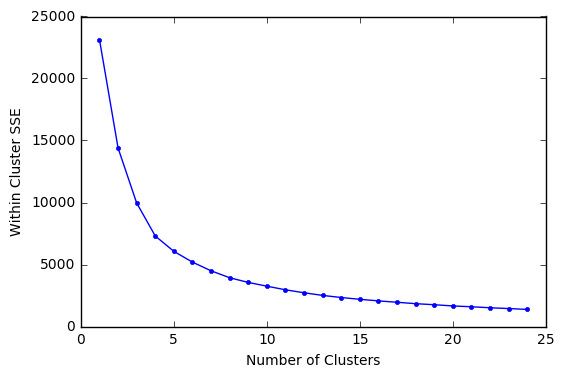

In [22]:
within_cluster_sse = []

for i in range(1, 25):
    km = KMeans(n_clusters=i, init='k-means++', max_iter=500, random_state=0)
    km.fit(x_scaled_pca)
    within_cluster_sse.append(km.inertia_)
    
plt.plot(range(1,25), within_cluster_sse, marker='.')
plt.xlabel('Number of Clusters')
plt.ylabel('Within Cluster SSE')
plt.show()

Based on the SSE vs. # Cluster plot above, we should be using about 5 or 6 clusters in the K-means algorithm.  I will rerun the algorithm and plot the results below.

In [23]:
cluster = KMeans(n_clusters=6, init='k-means++', max_iter=500, random_state=0)
x_cluster = cluster.fit_predict(x_scaled_pca)
x_cluster

array([5, 0, 2, ..., 4, 0, 5], dtype=int32)

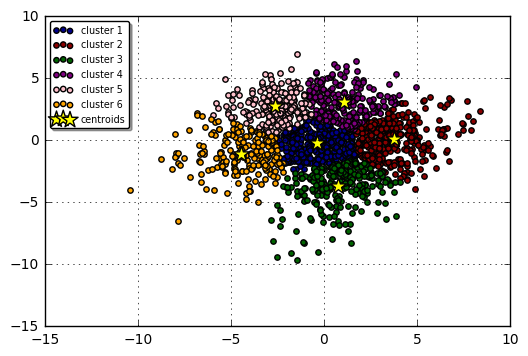

In [25]:
colors = ['darkblue','darkred','darkgreen','purple','pink','orange']
labels = ['cluster 1','cluster 2', 'cluster 3', 'cluster 4', 'cluster 5', 'cluster 6']

for group in range(0,6):
    plt.scatter(x_scaled_pca[x_cluster==group,0],
                x_scaled_pca[x_cluster==group,1],
                s=15,
                c=colors[group],
                label=labels[group])

plt.scatter(cluster.cluster_centers_[:,0],
            cluster.cluster_centers_[:,1],
            s=150,
            marker='*',
            c='yellow',
            label='centroids')


plt.legend(loc='upper left', fancybox=True, shadow=True, fontsize='x-small')
plt.grid()
plt.show()

As a final step in the process, I want to summarize the original statistics for each of our clusters to see the strongest indicators of similarity between teams.

In [26]:
teams_num['cluster'] = x_cluster + 1

In [35]:
cols = teams_num.columns[0:-1]
cols
summary = teams_num.groupby('cluster', as_index=False)[cols].mean()
summary = summary.sort_values('w',ascending=False)
summary.ix[:,:]

,cluster,ghome,w,l,r,ab,double,triple,hr,bb,...,dp,fp,attendance,bpf,ppf,single,gaway,obp,slg,whip
3,4,0.500109,0.566221,0.433282,4.414069,34.025527,1.607882,0.203513,0.920088,3.265312,...,0.886700,0.980498,0.014918,98.991031,98.291480,6.041185,0.499891,0.326541,0.398089,1.258895
4,5,0.499789,0.554748,0.445040,4.966149,34.410020,1.843793,0.189170,1.148231,3.504874,...,0.905835,0.982902,0.017013,100.990244,100.409756,6.067300,0.500211,0.339667,0.433370,1.339920
1,2,0.499825,0.516571,0.481630,3.950588,33.721607,1.323016,0.238333,0.695328,3.178863,...,0.921577,0.972977,0.008646,98.687097,98.274194,6.174137,0.500175,0.318480,0.365054,1.267060
0,1,0.499956,0.492567,0.506602,4.416696,34.131691,1.587464,0.223900,0.897026,3.242884,...,0.945744,0.976502,0.011248,100.700906,100.574018,6.178318,0.500044,0.328206,0.398742,1.369679
5,6,0.499971,0.454492,0.545215,4.839055,34.495204,1.809167,0.193512,1.087662,3.342791,...,0.982977,0.979833,0.013032,101.657143,102.200000,6.128928,0.500029,0.335507,0.425363,1.484290
2,3,0.500028,0.423382,0.574092,4.063207,33.945382,1.364987,0.245597,0.748544,3.283508,...,0.994481,0.970322,0.006083,100.582375,101.846743,6.224083,0.499972,0.322520,0.373531,1.425608


Here are a few interesting notes on the summarization of the original data:
1. Cluster 4 contains teams that average the most wins/fewer losses.  They don't score the most runs per game, nor have the best obp or slg, but they are pretty good in these offensive categories.  We do see that they the lowest WHIP among the 6 clusters, the second fewest runs against/earned runs/era, and the most saves.  This cluster indicates that the best teams have a good mix of both offense and pitching, but are not necessarily the best in either category.
2.  The best offensive clusters are clusters 5 and 6 based on having the highest OBP and SLG.  Cluster 5 teams tend to win more than they lose, while cluster 6 loses more frequently.  Cluster 5 scores the most runs and hits the most home runs among the clsuters.  The have the 3rd lowest WHIP, which indicates that cluster 5 teams have strong offenses, coupled with pretty good pitching.  Cluster 6 teams have the highest WHIP, highest ERA, and give up the most runs.  While this cluster is strong offensively, their poor pitching causes a losing record overall.
3.  Cluster 3 teams tend to have the fewest wins.  These are teams that don't have good pitching or offense, as indicated by the second worse OBP, SLG, WHIP, and ERA.  These teams also have the lowest attendance - which indicates we are probably seeing cases where fans lose faith in the team and don't attend the games.
4.  One thing to keep in mind in this summary is that we could have changes in performance stats over time.  Older teams may not have scored as much as modern teams, but could still have strong seasons.  Similarly, we see pretty strong differences in attendance by cluster, which could be an indication of poorer teams losing their fans' interest, or simply a shifting in attendance figures over time.